# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. 

**Цель:**
- Построить модель для задачи классификации, которая выберет подходящий тариф.

**Задачи:**
- Построить модель с максимально большим значением *accuracy*. 

**Условия:**
- Предобработка данных не понадобится. Выполнена в первой части проекта.
- Hекомендовано не использовать GridsearchCV и RandomsearchCV
- Довести долю правильных ответов по крайней мере до 0.75

# Обзор данных

In [1]:
import pandas as pd
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [2]:
try:
    df = pd.read_csv('/datasets/users_behavior.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
df.calls = df.calls.astype('int')
df.minutes = df.minutes.astype('int')

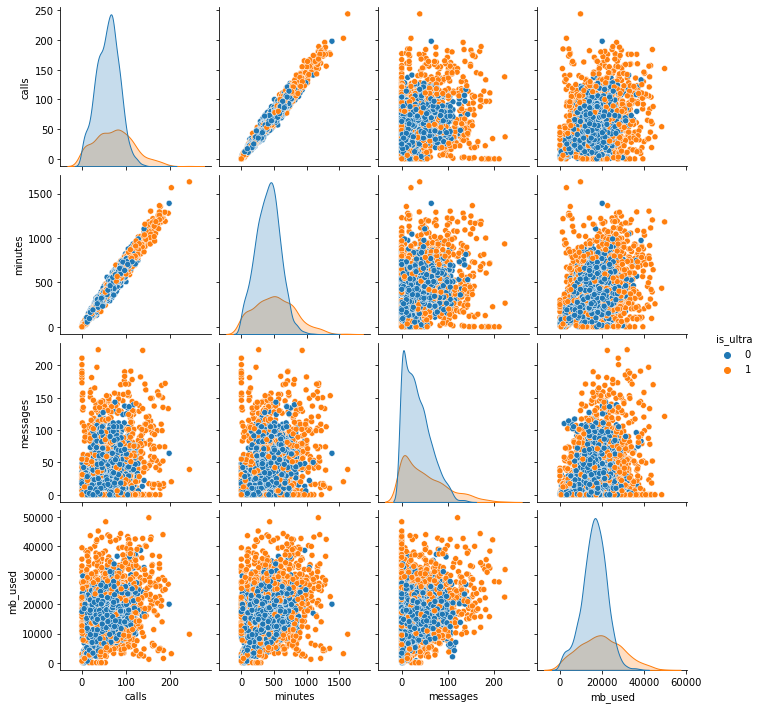

In [5]:
sns.pairplot(df, hue="is_ultra");

## Разделение данных на выборки

In [6]:
features = df.drop(['is_ultra'],axis=1)

In [7]:
target = df['is_ultra']

Сначала разделим датасет на тренировочную выборку (60%) и выборку для валидации и теста (40%)

In [8]:
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.4, random_state=12345)

Теперь разделим выборку для валидации и теста на 2 равные выборки

In [9]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5, random_state=12345)

Проверим выборки по количеству объектов:

In [10]:
features.shape

(3214, 4)

In [11]:
features_train.shape

(1928, 4)

In [12]:
features_valid.shape

(643, 4)

In [13]:
features_test.shape

(643, 4)

## Исследование моделей

### DecisionTreeClassifier

В этом проекте рекомендовано не использовать GridsearchCV и RandomsearchCV

Обучим модель на тренировочной выборке и сравним качество моделей на валидационной выборке с разными параметрами max_depth (от 1 до 5).

In [14]:
%%time

for depth in range(1, 6):
    model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_dtc.fit(features_train, target_train)
    predictions_valid = model_dtc.predict(features_valid)
    print("max_depth =", depth, ": ", end='')
    print(accuracy_score(target_valid, predictions_valid))

max_depth = 1 : 0.7542768273716952
max_depth = 2 : 0.7822706065318819
max_depth = 3 : 0.7853810264385692
max_depth = 4 : 0.7791601866251944
max_depth = 5 : 0.7776049766718507
CPU times: user 23.3 ms, sys: 7.4 ms, total: 30.7 ms
Wall time: 28.5 ms


Неплохой результат. Лучший показатель `accuracy` с глубиной: 3.

### RandomForestClassifier

Применим алгоритм классификации — `случайный лес`. Обучим модели с числом деревьев от 1 до 10 на основе тренировочной выборки, и выведем лучший результат `accuracy`, применив модель на валидационной выборке.

In [15]:
%%time

best_model_rfc = None
best_result_rfc = 0
for est in range(10, 301, 10):
    model_rfc = RandomForestClassifier(random_state=12345, n_estimators=est)
    model_rfc.fit(features_train, target_train)
    result_rfc = model_rfc.score(features_valid, target_valid)
    if result_rfc > best_result_rfc:
        best_model_rfc = model_rfc
        best_result_rfc = result_rfc
best_result_rfc, est

CPU times: user 18 s, sys: 109 ms, total: 18.1 s
Wall time: 18.1 s


(0.7962674961119751, 300)

### LogisticRegression

Пробуем алгоритм — логистическая регрессия. Количество итераций оставим по умолчанию (100).

In [16]:
%%time

model_lr = LogisticRegression(random_state=12345, solver='lbfgs')
model_lr.fit(features_train, target_train)
model_lr.predict(features_valid)
model_lr.score(features_valid, target_valid)

CPU times: user 46.6 ms, sys: 0 ns, total: 46.6 ms
Wall time: 51.7 ms


0.7558320373250389

### Вывод

Сравним результаты и выберем наиболее подходящую модель:

1. Качество (accuracy). У DecisionTreeClassifier, с глубиной 3 хороший результат - 0.785, как и у RandomForestClassifier - 0.798. У LogisticRegression показатель `accuracy` самый низкий: 0.755. Эта модель не подходит.
2. Скорость работы. Из двух оставшихся моделей, самая быстая - **DecisionTreeClassifier**, т.к. мы получили наилучший результат уже на 3ей проверке.

## Проверка на тестовой выборке

In [17]:
%%time

model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=3)
model_dtc.fit(features_train, target_train)
predictions_test = model_dtc.predict(features_test)
accuracy_score(target_test, predictions_test)

CPU times: user 9.1 ms, sys: 41 µs, total: 9.14 ms
Wall time: 8.07 ms


0.7791601866251944

Глубина 3 в тестовой выборке имеет результат (0.779), который удовлетворяет условию.

## Проверка на адекватность

Проверим модели на адекватность на основе вылидационной выборки

Используем для проверки модель DummyClassifier

In [18]:
model_dc = DummyClassifier(strategy='most_frequent', random_state=12345)
model_dc.fit(features_train, target_train)
result_dc = model_dc.score(features_test, target_test)
result_dc

0.6842923794712286

Результат `accuracy` модели DummyClassifier (0.684) меньше, чем у модели DecisionTreeClassifier (0.779). 

# Общий вывод

- Задача определена, как задача бинарной классификации. 

- Исходные данные были разделены на 3 выборки: Тренировочная (60%), валидационная (20%) и тестовая (20%).

- Были применены модели: Дерево решений (DecisionTreeClassifier), Cлучайный лес (RandomForestClassifier) и Логистическая регрессия (LogisticRegression). Использованы разные значения гперпараметров.

- Наиболее удачной признана модель DecisionTreeClassifier, с глубиной погружения 3.

- Проведено тестирование данной модели по тестовой выборке. Результат 0.779 -  удовлетворяет условию (не менее 0.75).

- Модель прошла проверку на адекватность.